In [ ]:
!pip cache purge
!pip install numpy==1.25.0 pandas gensim==4.3.2 pymorphy2==0.9.1 scipy==1.11.1 fasttext-wheel==0.9.2

Files removed: 53


In [ ]:
import pandas as pd
from tokenizers import Tokenizer, models, trainers, pre_tokenizers
import matplotlib.pyplot as plt
import numpy as np
import string
import pymorphy2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
import fasttext
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
import os
from tqdm import tqdm

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Чтение данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
categories = pd.read_csv("/content/drive/MyDrive/Диплом/categories.csv")
categories.name.to_list()

['Авиатранспорт',
 'Автосервисы',
 'Арбитражные слуги, третейские суды',
 'Техника: аудио-, видео-, фото-, кино-',
 'Аудио, видеопродукция, игры',
 'Биологически активные добавки',
 'Благотворительная деятельность',
 'Бытовая техника',
 'Бытовая химия',
 'Водный транспорт',
 'Грузовые автомобили',
 'Досуг и развлечения',
 'Компьютерная техника и ПО',
 'Косметика, уход, гигиена',
 'Легковые автомобили и мототехника',
 'Лекарственные препараты',
 'Массовые мероприятия',
 'Мебель и предметы интерьера',
 'Медицинское оборудование и материалы',
 'Напитки',
 'Общественные организации',
 'Одежда и обувь',
 'Оргтехника и канцелярские товары',
 'Отопительное и водонагревательное оборудование',
 'Парфюмерия',
 'Политическая реклама',
 'Посредничество и франчайзинг',
 'Продукты питания',
 'Промышленное оборудование',
 'Промышленные материалы',
 'Реклама социальная',
 'Рента',
 'Сертификация',
 'Изделие, конструктивно схожее с оружием',
 'Спортивные изделия',
 'Средства массовой информации',
 'Сре

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Диплом/anotates_string.csv")
data.head(10)

,Unnamed: 0,input,category
0,0,Каталог автозапчастей для интернет-магазинов....,Автосервисы
1,1,Оборудование для ресторанов - профессиональное...,Услуги общественного питания
2,2,"Легковые автомобили, запчасти на автомобили, ш...",Легковые автомобили и мототехника
3,3,Сьогодні Рош створює інноваційні ліки та діаг...,Лекарственные препараты
4,4,Белгидрохимресурс Компания ЗАО «Белгидрохимрес...,Промышленные материалы
5,5,"Делаем ремонт | Портал для тех, кто делает рем...","Строительные, отделочные материалы, сантехника"
6,6,ФГБУ «Институт стандартизации» ФГБУ «Институт ...,Сертификация
7,7,Туристическая деревня НАГЕУС,"Туризм, спорт и отдых"
8,8,Магазин развивающих игр и литературы «Маленьки...,Товары для детей
9,9,Агентство деловых поездок Оптима Турс: гостини...,"Туризм, спорт и отдых"


# Изучение данных

In [ ]:
# всего уникальных категорий
len(categories)

72

In [ ]:
# всего текстов
len(data)

2971

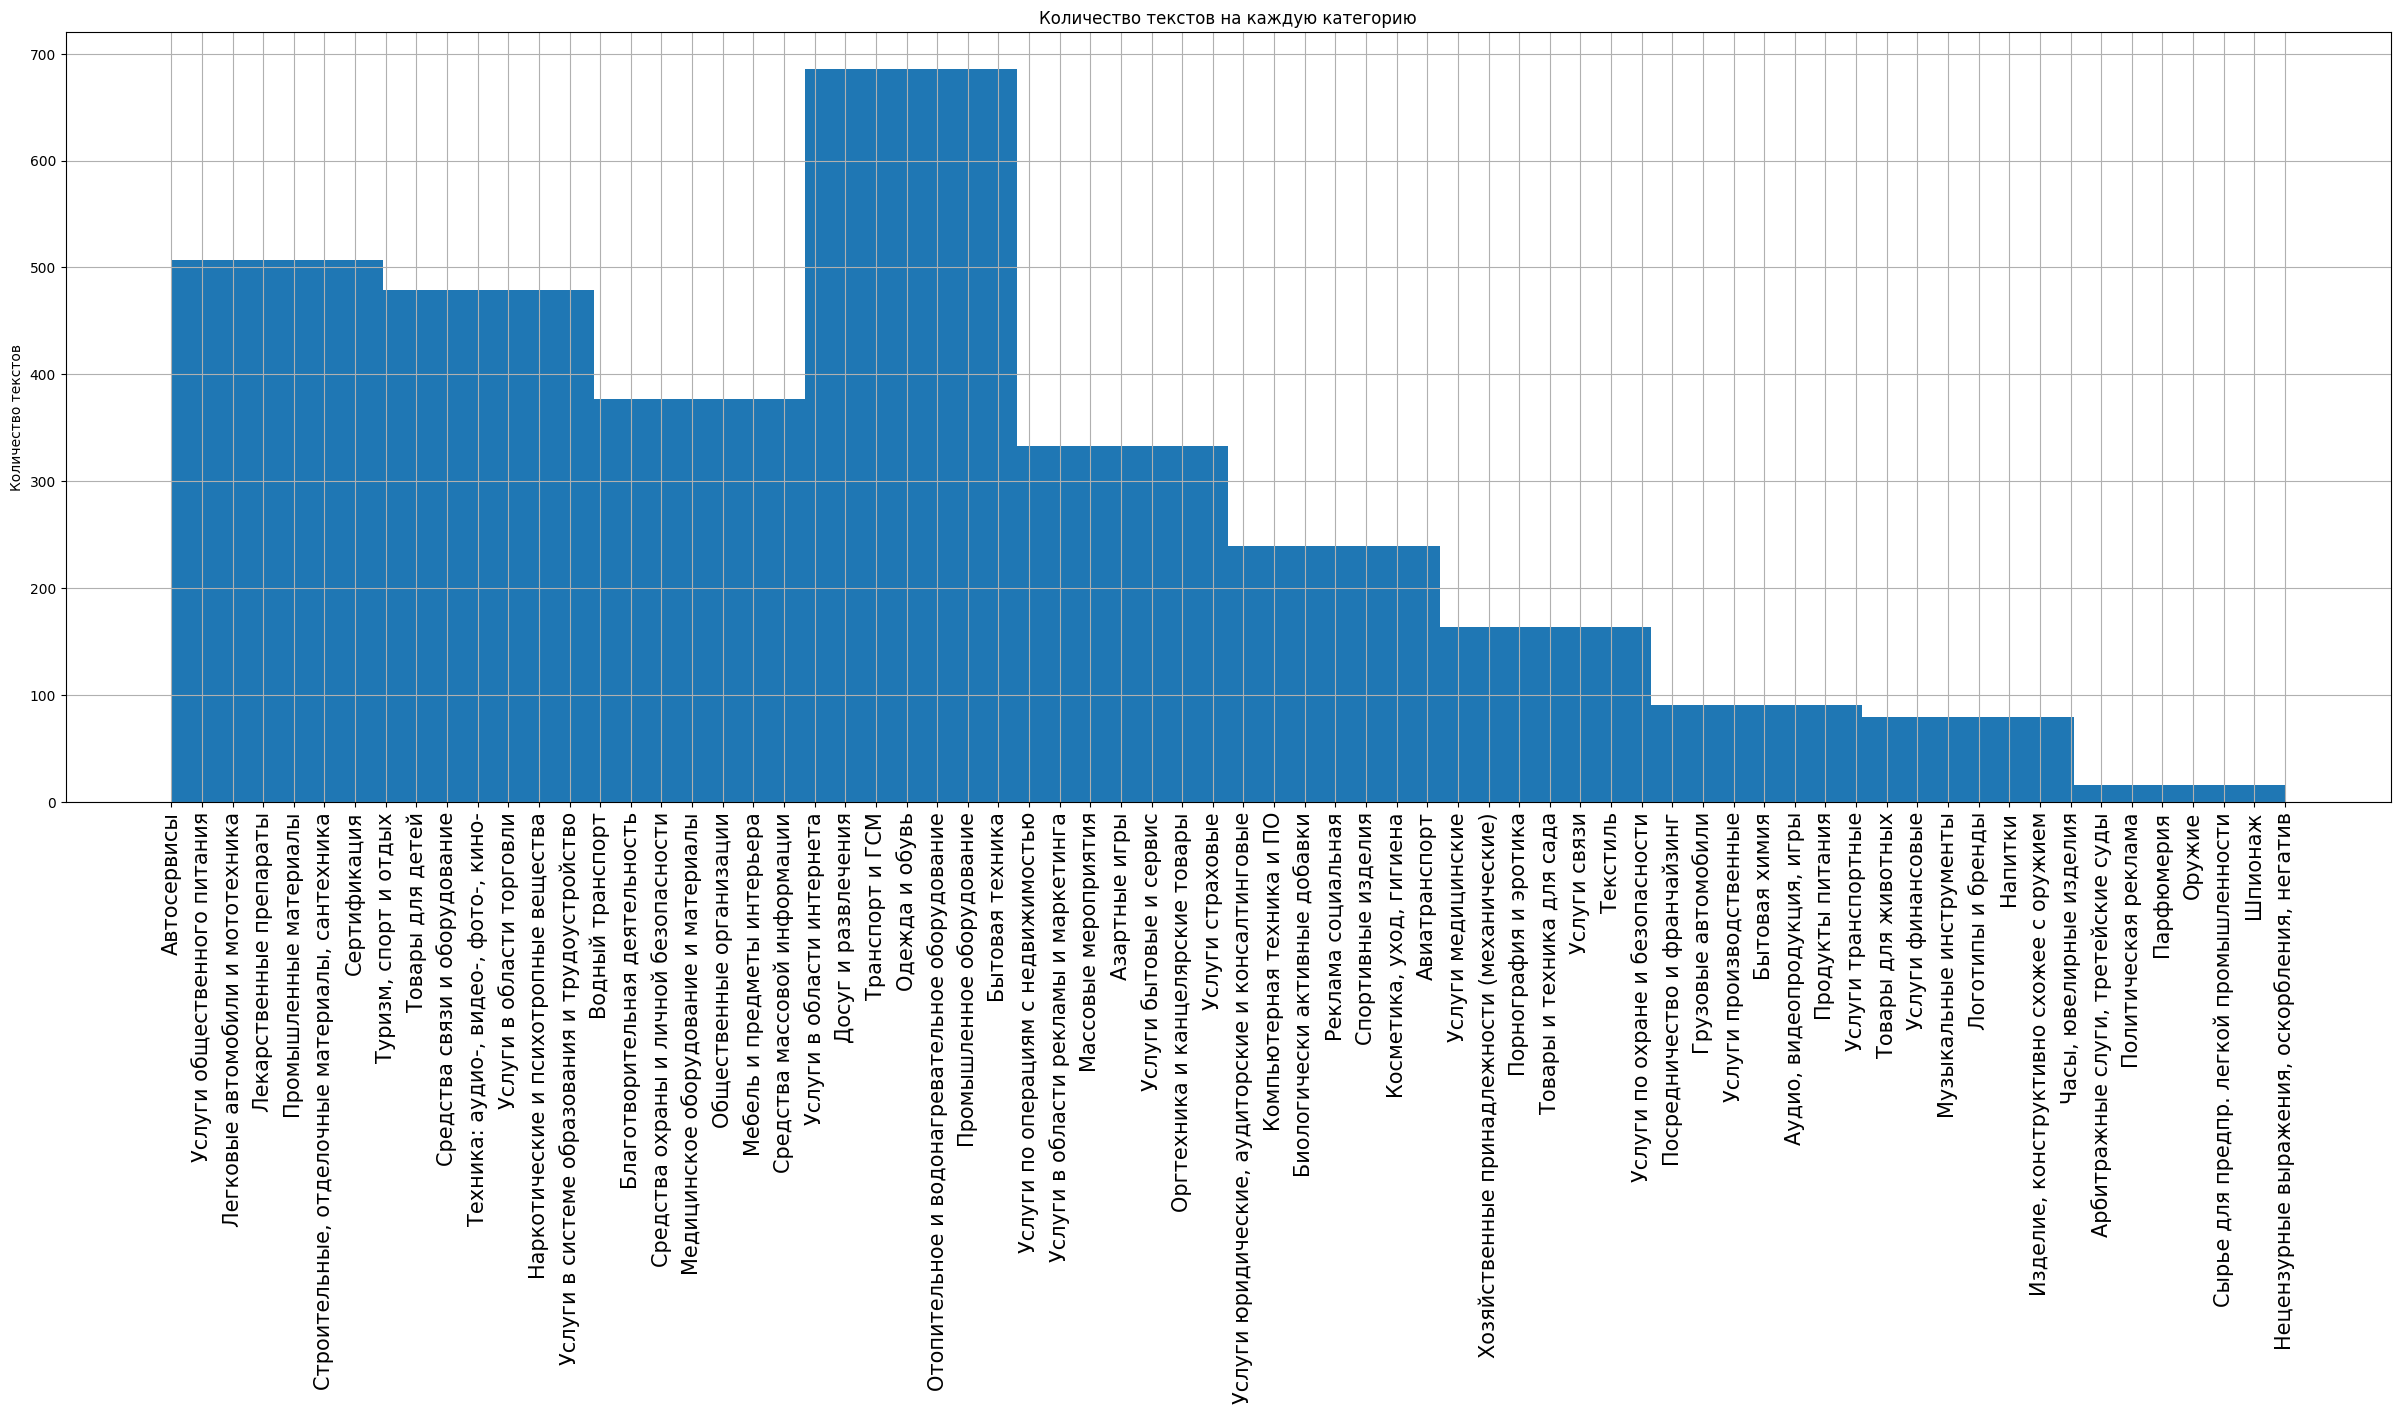

In [ ]:
# Количество текстов на каждую категорию
data['category'].hist(xlabelsize=15, xrot=90, bins=10, figsize=(30, 10))
plt.title('Количество текстов на каждую категорию')
plt.ylabel('Количество текстов')

plt.savefig("categories_rate.png")
plt.show()

Заметим, что для двух категорий текстов нет совсем. Не будем обучать модель предсказывать категории для данных направлений.  

In [ ]:
len(data['category'].value_counts()) == len(categories['name'])

False

In [ ]:
set(categories['name']) - set(data['category'])

{'Рента', 'Табак и курительные принадлежности'}

In [ ]:
categories[categories['name'] == 'Рента'].index

Index([31], dtype='int64')

In [ ]:
categories[categories['name'] == 'Табак и курительные принадлежности'].index

Index([67], dtype='int64')

In [ ]:
categories.drop([31, 67], axis=0, inplace=True)
CATEGORIES_NUM = len(categories)
CATEGORIES_NUM

70

In [ ]:
def drop_punctuation(line, sym):
  for p in sym:
    if p in line:
        line = line.replace(p, '')
  return line

In [ ]:
# Средний объем текста по которому предстоит предсказывать категорию

# убрали знаки препинания
data['input_non_punct'] = data['input'].apply(lambda x: drop_punctuation(x, string.punctuation))

data['length'] = data['input_non_punct'].apply(lambda x: len(x.split()))
print("Среднее количество слов в описании объявления:", np.mean(data['length']))
print("Медиана в количестве слов в описании объявления:", np.median(data['length']))
print("Минимальное количество слов в описании объявления:", np.min(data['length']))
print("Максимальное количество слов в описании объявления:", np.max(data['length']))

Среднее количество слов в описании объявления: 15.422080107707842
Медиана в количестве слов в описании объявления: 11.0
Минимальное количество слов в описании объявления: 2
Максимальное количество слов в описании объявления: 49


In [ ]:
# в текстах содержатся два вида описания объявлений: заголовок и само описание
# длина почти всех заголовков равна 2
data[data['length'] == 2]['input']

,input
11,Телевизиони Тоҷикистон
27,НЕЙРОСЕССИИ ИНТЕРАУРА
35,Интернет-магазин Строй-Март
127,Производство листогибов
174,Декоративный камень
216,Типография Типография
222,Главная - Столетие.RU
576,Павловская Жемчужина
593,ГИПРОСВЯЗЬ || Москва
601,Молодежный Смоленск


## Выводы

1. В тексте присутствует пунктуация, необходимо очистить текст от знаков препинания перед обучением модели.

2. Предназначенный для обучения модели текст может быть коротким - 2 слова. Как правило, первое слово, это прилагательное. В зависимости от рода и числа, прилагательные изменяют свои окончания, но корень слова остается неизменным, так же как и смысл. Необходимо токенизировать слова так, чтобы "эффект морфологии" русского языка сохранился.

# Препроцессинг текста

## Удаление знаков препринания, спецсимволов

In [ ]:
symbols_to_avoid = string.punctuation
symbols_to_avoid

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# расширим список символов
# добавим тире, кавычки, знаки валют
symbols_to_avoid += '—«»“”‘’$€£¥₽'
symbols_to_avoid

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~—«»“”‘’$€£¥₽'

In [ ]:
data.drop("input_non_punct", axis=1, inplace=True)
data['input_non_punct'] = data["input"].apply(lambda x: drop_punctuation(x, symbols_to_avoid))

## Нормализация текста

In [ ]:
def pymorphy2_311_hotfix():
    from inspect import getfullargspec
    from pymorphy2.units.base import BaseAnalyzerUnit

    def _get_param_names_311(klass):
        if klass.__init__ is object.__init__:
            return []
        args = getfullargspec(klass.__init__).args
        return sorted(args[1:])

    setattr(BaseAnalyzerUnit, '_get_param_names', _get_param_names_311)

In [ ]:
pymorphy2_311_hotfix()
morph = pymorphy2.MorphAnalyzer()

In [ ]:
# parse(word) возвращает список вариантов разбора слова, возьмем первый как наиболее вероятный
def normilise_text(text, morph):
  return ' '.join([morph.parse(word)[0].normal_form for word in text.split() if word != ''])

In [ ]:
data['tokens'] = data['input_non_punct'].apply(lambda x: normilise_text(x, morph))
data['tokens'].head(10)

,tokens
0,каталог автозапчастей для интернетмагазин раб...
1,оборудование для ресторан профессиональный кух...
2,легковой автомобиль запчасть на автомобиль шин...
3,сьогодні рош створює інноваційні ліка тот діа...
4,белгидрохимресурс компания зао белгидрохимресу...
5,делать ремонт портал для тот кто делать ремонт...
6,фгб институт стандартизация фгб институт станд...
7,туристический деревня нагеус
8,магазин развивать игра и литература маленький...
9,агентство деловой поездка оптим турс гостиница...


# Train-test split

In [ ]:
df_train, df_tmp = train_test_split(data,
                                  test_size=0.2,
                                  random_state=42)
df_val, df_test = train_test_split(df_tmp,
                                   test_size=0.5,
                                   random_state=42)

# Метрики



## Recall

In [ ]:
def recall_count(predicted_map, target_map):
  res = []
  for category_id in predicted_map.keys():
    res.append(predicted_map[category_id] / target_map[category_id])
  return np.mean(res) # макро усреднение

## Precision

In [ ]:
def precision_count(predicted_correct_map, predicted_all_map):
  res = []
  for category_id in predicted_correct_map.keys():
    res.append(predicted_correct_map[category_id] / predicted_all_map[category_id])
  return np.mean(res) # макро усреднение

# Векторизация

Реализуем несколько вариантов, чтобы потом выбрать наиболее подходящий.

## CountVectorizer

In [ ]:
vectorizer = CountVectorizer(analyzer='word', min_df=10)

df_train['count_vectorizer'] = [vec for vec in vectorizer.fit_transform(df_train['tokens']).toarray()]
df_val['count_vectorizer'] = [vec for vec in vectorizer.transform(df_val['tokens']).toarray()]

In [ ]:
import pickle
with open('./vectorizer.bin', 'wb') as f:
  pickle.dump(vectorizer, file=f)

## Word2Vec

Модель Word2Vec можно обучить двумя способами: Skip-gram и CBOW. Выбор определяется параметром sg (1 — Skip-gram, 0 — CBOW). CBOW обычно хорошо работает на небольших наборах данных.

In [ ]:
# создадим список токенизированных предложений
df_train['tokens_list'] = df_train['tokens'].apply(lambda x: x.split()).tolist()
df_val['tokens_list'] = df_val['tokens'].apply(lambda x: x.split()).tolist()

In [ ]:
vectorizer_w2v = Word2Vec(df_train['tokens_list'], vector_size=1040, window=5, min_count=2, sg=0)
vectorizer_w2v.train(df_train['tokens_list'], epochs=1, total_examples=vectorizer_w2v.corpus_count)

(26348, 36426)

In [ ]:
# длина получившегося словаря
vocab = set(vectorizer_w2v.wv.key_to_index.keys())
len(vocab)

3442

In [ ]:
def get_vector_for_word(sentence, d, model):
  vectors = []
  for word in sentence:
    if word in d:
      vectors.append(model.wv.get_vector(word))
    else:
      vectors.append(np.zeros(1040))
    return np.array(vectors).mean(axis=0)

In [ ]:
df_train['word_2_vec'] = df_train['tokens_list'].apply(lambda x: get_vector_for_word(x, vocab, vectorizer_w2v))
df_val['word_2_vec'] = df_val['tokens_list'].apply(lambda x: get_vector_for_word(x, vocab, vectorizer_w2v))

## FastText

In [ ]:
with open("fasttext_vectorizer_input.txt", "w") as file:
    for line in df_train['tokens']:
      file.write(line)

In [ ]:
fasttext_vectorizer = fasttext.train_unsupervised(
    "fasttext_vectorizer_input.txt",
    dim = 1040,
    epoch = 1,
    lr = 0.1,
    minn = 3,
    maxn = 6,
    wordNgrams = 5,
    thread = 6,
    lrUpdateRate = 100,
    ws = 5)

In [ ]:
df_train['fast_text'] = df_train['tokens'].apply(lambda text: fasttext_vectorizer.get_sentence_vector(text.lower().replace('\n', ' ')))
df_val['fast_text'] = df_val['tokens'].apply(lambda text: fasttext_vectorizer.get_sentence_vector(text.lower().replace('\n', ' ')))

In [ ]:
categories['name']

,name
0,Авиатранспорт
1,Автосервисы
2,"Арбитражные слуги, третейские суды"
3,"Техника: аудио-, видео-, фото-, кино-"
4,"Аудио, видеопродукция, игры"
...,...
66,Сырье для предпр. легкой промышленности
68,"Нецензурные выражения, оскорбления, негатив"
69,Порнография и эротика
70,Шпионаж


# Кодирование категорий

In [ ]:
# str:int
category_encoded_map = dict()
for i, c in enumerate(categories['name']):
  category_encoded_map[c] = i

In [ ]:
# int:str
category_encoded_map_reversed = dict()
for category, category_id in category_encoded_map.items():
  category_encoded_map_reversed[category_id] = category

In [ ]:
def encode_category(category_id):
  vec_encoded = np.zeros(CATEGORIES_NUM)
  vec_encoded[category_id] = 1
  return vec_encoded

In [ ]:
df_train['category_encoded'] = df_train['category'].apply(lambda x: encode_category(category_encoded_map[x]))
df_val['category_encoded'] = df_val['category'].apply(lambda x: encode_category(category_encoded_map[x]))
df_test['category_encoded'] = df_test['category'].apply(lambda x: encode_category(category_encoded_map[x]))

# Обучение модели

## Подготовка совместимости с библиотекой pytorch

In [ ]:
class My_dataset(Dataset):
    def __init__(self, df, text_column):
        self.vecs = df[text_column].values
        self.cat = df['category_encoded'].values

    def __getitem__(self, index):
        return self.vecs[index], self.cat[index]

    def __len__(self):
        return len(self.vecs)

In [ ]:
class My_model(nn.Module):
    def __init__(self, size_in, size_hide, size_out):
        super().__init__()
        self.linear_1 = nn.Linear(size_in, size_hide)
        self.bn = nn.BatchNorm1d(size_hide)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.dp = nn.Dropout(0.8)
        self.linear_2 = nn.Linear(size_hide, size_out)

    def forward(self, x):
        x = x.to(torch.float32)
        x = self.linear_1(x)
        x = self.bn(x)
        x = self.tanh(x)
        # x = self.relu(x)
        x = self.dp(x)
        x = self.linear_2(x)
        return x

    def predict(self, input, drop_punctuation, normilise_text, vectorizer, device='cpu'):
        clear_text = drop_punctuation(input, symbols_to_avoid)
        tokens_text = normilise_text(clear_text, morph)
        text_vector = vectorizer.transform([tokens_text]).toarray()[0]

        output = self.forward(torch.tensor([text_vector])).detach().numpy()

        category_id = np.argmax(output)
        return category_encoded_map_reversed[category_id]

In [ ]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

In [ ]:
# размер вектора
len(df_train['fast_text'].values[0])

1040

In [ ]:
def init_my_model(device, size_in):

  model = My_model(size_in=size_in,
                   size_hide=CATEGORIES_NUM,
                   size_out=CATEGORIES_NUM).to(device)

  model.train()
  return model

## Определение функции потерь

Посчитаем веса для каждой категории.

Вспомним, что тексты неравномерно распределены по категориям. Чтобы примерно сбалансировать данные, выставим веса так, чтобы менее часто встречаемые категории, имели большие веса.

In [ ]:
# подсчет весов для каждой категории
def init_my_categories_weights_map(df):
  count_categories = dict(df['category'].value_counts())
  count_categories_max = max(count_categories.values())

  categories_weights_map = dict()
  for category in count_categories.keys():
    categories_weights_map[category] = count_categories_max / count_categories[category]

  return categories_weights_map

In [ ]:
categories_weights_map = init_my_categories_weights_map(df_train)
df_train['weights'] = df_train['category'].apply(lambda x: categories_weights_map[x])
df_val['weights'] = df_val['category'].apply(lambda x: categories_weights_map[x])

In [ ]:
def init_my_optimizer(model):
  return torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
def init_my_criterion(df, device):
  categories_weights_map = init_my_categories_weights_map(df)
  return torch.nn.CrossEntropyLoss(weight=torch.tensor(list(categories_weights_map.values())).float().to(device))

## Обучение модели

In [ ]:
def train_my_model(epochs, model, train_loader, val_loader, device, criterion, optimizer):
  for epoch_num in range(epochs):

      # for accuracy
      train_correct_predicted_count = 0
      val_correct_predicted_count = 0

      # for recall
      train_correct_predicted_map = dict()
      train_target_map = dict()
      val_correct_predicted_map = dict()
      val_target_map = dict()

      # for precision
      train_all_predicted_map = dict()
      val_all_predicted_map = dict()

      train_loss = 0
      val_loss = 0

      model.train()
      for data, hubs in tqdm(train_loader):
          data = data.to(device)
          hubs = hubs.to(device)
          output = model(data)
          loss = criterion(output, hubs)
          train_loss += loss.item()
          output = output.detach().cpu().numpy()
          hubs = hubs.detach().cpu().numpy()

          # итерируемся по текстам из батча
          for i in range(len(output)):
              output_i = output[i]
              category_id_predicted = np.argmax(output_i)
              category_id_target = np.argmax(hubs[i])
              if category_id_predicted == category_id_target:
                train_correct_predicted_count += 1
                if category_id_predicted in train_correct_predicted_map.keys():
                  train_correct_predicted_map[category_id_predicted] += 1
                else:
                  train_correct_predicted_map[category_id_predicted] = 1

              if category_id_predicted in train_all_predicted_map.keys():
                train_all_predicted_map[category_id_predicted] += 1
              else:
                train_all_predicted_map[category_id_predicted] = 1
              if category_id_target in train_target_map.keys():
                train_target_map[category_id_target] += 1
              else:
                train_target_map[category_id_target] = 1

          model.zero_grad()
          loss.backward()
          optimizer.step()

      model.eval()
      for data, hubs in tqdm(val_loader):
          data = data.to(device)
          hubs = hubs.to(device)
          output = model(data)
          loss = criterion(output, hubs)
          val_loss += loss.item()
          output = output.detach().cpu().numpy()
          hubs = hubs.detach().cpu().numpy()
          for i in range(len(output)):
              output_i = output[i]
              category_id_predicted = np.argmax(output_i)
              category_id_target = np.argmax(hubs[i])

              if category_id_predicted == category_id_target:
                val_correct_predicted_count += 1

                if category_id_predicted in val_correct_predicted_map.keys():
                  val_correct_predicted_map[category_id_predicted] += 1
                else:
                  val_correct_predicted_map[category_id_predicted] = 1

              if category_id_predicted in val_all_predicted_map.keys():
                val_all_predicted_map[category_id_predicted] += 1
              else:
                val_all_predicted_map[category_id_predicted] = 1

              if category_id_target in val_target_map.keys():
                val_target_map[category_id_target] += 1
              else:
                val_target_map[category_id_target] = 1

      train_recall = recall_count(train_correct_predicted_map, train_target_map)
      val_recall = recall_count(val_correct_predicted_map, val_target_map)

      train_pr = precision_count(train_correct_predicted_map, train_all_predicted_map)
      val_pr = precision_count(val_correct_predicted_map, val_all_predicted_map)


      print(
          f"Epochs: {epoch_num + 1} | Train Loss: {train_loss} Train Precision: {train_pr} Train Recall: {train_recall} \
          " + "\n" + " "*len(str(epoch_num + 1)) +
  f"         | Vsl Loss {val_loss} Val Precision: {val_pr} | Val Recall: {val_recall}")


In [ ]:
# fast_text vectorizer

set_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device - ", device)

model = init_my_model(device, 1040)

train_data = My_dataset(df_train, "fast_text")
val_data = My_dataset(df_val, "fast_text")

batch_size = 2048
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

optimizer = init_my_optimizer(model)
criterion = init_my_criterion(df_train, device)

train_my_model(epochs=20, model=model, train_loader=train_loader, val_loader=val_loader, device=device, criterion=criterion, optimizer=optimizer)

device -  cpu


100%|██████████| 1/1 [00:00<00:00, 114.33it/s]


Epochs: 1 | Train Loss: 159.30313078095185 Train Precision: 0.04800667291304894 Train Recall: 0.042163667995370656           
          | Vsl Loss 68.77884697920511 Val Precision: 0.06397306397306397 | Val Recall: 1.0


100%|██████████| 1/1 [00:00<00:00, 124.90it/s]


Epochs: 2 | Train Loss: 156.84380324757765 Train Precision: 0.05087731462752866 Train Recall: 0.05733086158396376           
          | Vsl Loss 66.59433214255628 Val Precision: 0.06397306397306397 | Val Recall: 1.0


100%|██████████| 1/1 [00:00<00:00, 103.76it/s]


Epochs: 3 | Train Loss: 137.75295578021596 Train Precision: 0.07524965276263362 Train Recall: 0.08347806252443761           
          | Vsl Loss 65.01872438208876 Val Precision: 0.06397306397306397 | Val Recall: 1.0


100%|██████████| 1/1 [00:00<00:00, 128.78it/s]


Epochs: 4 | Train Loss: 150.3382583127335 Train Precision: 0.07789334909962993 Train Recall: 0.08123925419626671           
          | Vsl Loss 63.98881741281132 Val Precision: 0.06397306397306397 | Val Recall: 1.0


100%|██████████| 1/1 [00:00<00:00, 103.39it/s]


Epochs: 5 | Train Loss: 147.2755442441793 Train Precision: 0.06771684636324045 Train Recall: 0.16049646089671946           
          | Vsl Loss 63.26611343599989 Val Precision: 0.06397306397306397 | Val Recall: 1.0


100%|██████████| 1/1 [00:00<00:00, 99.42it/s]


Epochs: 6 | Train Loss: 143.45595625306186 Train Precision: 0.1699490053104254 Train Recall: 0.08859993603694287           
          | Vsl Loss 62.949577231465405 Val Precision: 0.06397306397306397 | Val Recall: 1.0


100%|██████████| 1/1 [00:00<00:00, 118.66it/s]


Epochs: 7 | Train Loss: 141.85724277097484 Train Precision: 0.09998048819342328 Train Recall: 0.13380085604983794           
          | Vsl Loss 62.88652015975588 Val Precision: 0.06418918918918919 | Val Recall: 1.0


100%|██████████| 1/1 [00:00<00:00, 72.14it/s]


Epochs: 8 | Train Loss: 152.6911419144063 Train Precision: 0.0678064680245353 Train Recall: 0.1024531780920861           
          | Vsl Loss 62.94789633954326 Val Precision: 0.06440677966101695 | Val Recall: 1.0


100%|██████████| 1/1 [00:00<00:00, 99.44it/s]


Epochs: 9 | Train Loss: 131.3998570296048 Train Precision: 0.05649796789864901 Train Recall: 0.1671224227447321           
          | Vsl Loss 63.007868097976576 Val Precision: 0.06551724137931035 | Val Recall: 1.0


100%|██████████| 1/1 [00:00<00:00, 114.63it/s]


Epochs: 10 | Train Loss: 144.41244919117827 Train Precision: 0.08784994916128053 Train Recall: 0.16129720151560273           
           | Vsl Loss 63.04285571253007 Val Precision: 0.06620209059233449 | Val Recall: 1.0


100%|██████████| 1/1 [00:00<00:00, 113.52it/s]


Epochs: 11 | Train Loss: 141.02135583496408 Train Precision: 0.07486411362828586 Train Recall: 0.12439715967374917           
           | Vsl Loss 63.81185941213381 Val Precision: 0.0636042402826855 | Val Recall: 0.9473684210526315


100%|██████████| 1/1 [00:00<00:00, 92.23it/s]


Epochs: 12 | Train Loss: 136.5056250267312 Train Precision: 0.07578681548663244 Train Recall: 0.13747683036029343           
           | Vsl Loss 64.42802020248018 Val Precision: 0.5317164179104478 | Val Recall: 0.49282296650717705


100%|██████████| 1/1 [00:00<00:00, 110.65it/s]


Epochs: 13 | Train Loss: 130.8492444706071 Train Precision: 0.12084157572201963 Train Recall: 0.19256786169132434           
           | Vsl Loss 64.10870936491116 Val Precision: 0.3624512566532889 | Val Recall: 0.36511733880154934


100%|██████████| 1/1 [00:00<00:00, 106.94it/s]


Epochs: 14 | Train Loss: 127.24976944730503 Train Precision: 0.09446893931299484 Train Recall: 0.20547834885752625           
           | Vsl Loss 63.464074394172115 Val Precision: 0.3503326592221343 | Val Recall: 0.31337181337181336


100%|██████████| 1/1 [00:00<00:00, 98.80it/s]


Epochs: 15 | Train Loss: 131.54167316434473 Train Precision: 0.06234946014968556 Train Recall: 0.12643910502108244           
           | Vsl Loss 63.197559862953376 Val Precision: 0.3675 | Val Recall: 0.1147186147186147


100%|██████████| 1/1 [00:00<00:00, 116.12it/s]


Epochs: 16 | Train Loss: 130.14857155316554 Train Precision: 0.07350172301591075 Train Recall: 0.20959389002564205           
           | Vsl Loss 62.88170698839907 Val Precision: 0.3945035460992908 | Val Recall: 0.6363636363636364


100%|██████████| 1/1 [00:00<00:00, 111.00it/s]


Epochs: 17 | Train Loss: 130.158344821956 Train Precision: 0.08037299503439702 Train Recall: 0.211280696191684           
           | Vsl Loss 62.94860333249487 Val Precision: 0.5190311418685121 | Val Recall: 0.6363636363636364


100%|██████████| 1/1 [00:00<00:00, 100.48it/s]


Epochs: 18 | Train Loss: 129.30019661964732 Train Precision: 0.09520425498127984 Train Recall: 0.1556735665733648           
           | Vsl Loss 63.56945860482315 Val Precision: 0.5187713310580204 | Val Recall: 0.5454545454545454


100%|██████████| 1/1 [00:00<00:00, 103.41it/s]


Epochs: 19 | Train Loss: 125.76194895240855 Train Precision: 0.09225455657073335 Train Recall: 0.15398957606851962           
           | Vsl Loss 65.41449267409992 Val Precision: 0.5189003436426117 | Val Recall: 0.5454545454545454


100%|██████████| 1/1 [00:00<00:00, 124.39it/s]

Epochs: 20 | Train Loss: 127.42770044616631 Train Precision: 0.08150103190854627 Train Recall: 0.2125748809354582           
           | Vsl Loss 66.0742099150237 Val Precision: 0.5189003436426117 | Val Recall: 0.5454545454545454


# Эксперименты

## Выбор метода векторизации

In [ ]:
# word_2_vec

set_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device - ", device)

model = init_my_model(device, 1040)

train_data = My_dataset(df_train, "word_2_vec")
val_data = My_dataset(df_val, "word_2_vec")

batch_size = 2048
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

optimizer = init_my_optimizer(model)
criterion = init_my_criterion(df_train, device)

train_my_model(epochs=20, model=model, train_loader=train_loader, val_loader=val_loader, device=device, criterion=criterion, optimizer=optimizer)

device -  cpu


100%|██████████| 1/1 [00:00<00:00, 35.20it/s]


Epochs: 1 | Train Loss: 166.22295909677723 Train Precision: 0.06432904960525081 Train Recall: 0.04457348588421247           
          | Vsl Loss 69.74711776578539 Val Precision: 0.050070740546931024 | Val Recall: 0.30980861244019137


100%|██████████| 1/1 [00:00<00:00, 101.79it/s]


Epochs: 2 | Train Loss: 162.67932179757497 Train Precision: 0.04794097360595243 Train Recall: 0.03005223935757395           
          | Vsl Loss 70.78969664115561 Val Precision: 0.09159754224270353 | Val Recall: 0.34545454545454546


100%|██████████| 1/1 [00:00<00:00, 102.37it/s]


Epochs: 3 | Train Loss: 144.9290395985323 Train Precision: 0.0524926758311881 Train Recall: 0.045668973596312466           
          | Vsl Loss 72.03549122440036 Val Precision: 0.06632362346648062 | Val Recall: 0.28131517605201817


100%|██████████| 1/1 [00:00<00:00, 89.47it/s]


Epochs: 4 | Train Loss: 157.07919650646517 Train Precision: 0.05977246552965112 Train Recall: 0.05323831764645783           
          | Vsl Loss 72.15202376082657 Val Precision: 0.05261288912728212 | Val Recall: 0.28131517605201817


100%|██████████| 1/1 [00:00<00:00, 96.02it/s]


Epochs: 5 | Train Loss: 155.43754785799507 Train Precision: 0.057000751335390405 Train Recall: 0.04871712961499643           
          | Vsl Loss 71.39423199972997 Val Precision: 0.04666666666666667 | Val Recall: 0.3684210526315789


100%|██████████| 1/1 [00:00<00:00, 16.82it/s]


Epochs: 6 | Train Loss: 148.5798440333698 Train Precision: 0.05554319957535961 Train Recall: 0.060731031729180575           
          | Vsl Loss 70.42386772692115 Val Precision: 0.22302631578947368 | Val Recall: 0.2296650717703349


100%|██████████| 1/1 [00:00<00:00, 46.45it/s]


Epochs: 7 | Train Loss: 150.12600264152383 Train Precision: 0.06521675501266141 Train Recall: 0.0716290971800699           
          | Vsl Loss 69.79649885028442 Val Precision: 0.0933641975308642 | Val Recall: 0.30861244019138756


100%|██████████| 1/1 [00:00<00:00, 100.47it/s]


Epochs: 8 | Train Loss: 162.73665078414868 Train Precision: 0.0537050608743796 Train Recall: 0.06569615927246801           
          | Vsl Loss 69.04561554983091 Val Precision: 0.0869047619047619 | Val Recall: 0.12440191387559808


100%|██████████| 1/1 [00:00<00:00, 81.00it/s]


Epochs: 9 | Train Loss: 136.79854506703668 Train Precision: 0.04403778902350417 Train Recall: 0.08873096019125759           
          | Vsl Loss 68.39115129477361 Val Precision: 0.13636363636363635 | Val Recall: 0.15789473684210525


100%|██████████| 1/1 [00:00<00:00, 96.06it/s]


Epochs: 10 | Train Loss: 151.76493740586682 Train Precision: 0.05587323836182638 Train Recall: 0.07966447251920798           
           | Vsl Loss 67.42339600013958 Val Precision: 0.14285714285714285 | Val Recall: 0.15789473684210525


100%|██████████| 1/1 [00:00<00:00, 91.05it/s]
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epochs: 11 | Train Loss: 147.79735500789414 Train Precision: 0.11470867383479343 Train Recall: 0.1726645957809485           
           | Vsl Loss 66.62836153674533 Val Precision: nan | Val Recall: nan


100%|██████████| 1/1 [00:00<00:00, 72.50it/s]


Epochs: 12 | Train Loss: 143.59084431483154 Train Precision: 0.13758322510493473 Train Recall: 0.07931238675648018           
           | Vsl Loss 65.95583554461444 Val Precision: 0.02564102564102564 | Val Recall: 0.09090909090909091


100%|██████████| 1/1 [00:00<00:00, 73.38it/s]


Epochs: 13 | Train Loss: 143.2613677910852 Train Precision: 0.06037178606992404 Train Recall: 0.1458096140963124           
           | Vsl Loss 65.1423122643587 Val Precision: 0.06657848324514991 | Val Recall: 0.25


100%|██████████| 1/1 [00:00<00:00, 62.50it/s]


Epochs: 14 | Train Loss: 135.16091378786064 Train Precision: 0.04930929835360139 Train Recall: 0.09883414753459167           
           | Vsl Loss 64.4989735946744 Val Precision: 0.06321839080459771 | Val Recall: 0.25


100%|██████████| 1/1 [00:00<00:00, 72.08it/s]


Epochs: 15 | Train Loss: 139.61296781205428 Train Precision: 0.13730946425364343 Train Recall: 0.08081515071419014           
           | Vsl Loss 64.07050385131696 Val Precision: 0.04673913043478261 | Val Recall: 0.20454545454545456


100%|██████████| 1/1 [00:00<00:00, 71.93it/s]


Epochs: 16 | Train Loss: 139.29979819965246 Train Precision: 0.045877185551248395 Train Recall: 0.09476056125278116           
           | Vsl Loss 63.607962858894204 Val Precision: 0.03553921568627451 | Val Recall: 0.20454545454545456


100%|██████████| 1/1 [00:00<00:00, 73.67it/s]


Epochs: 17 | Train Loss: 139.17148853095063 Train Precision: 0.047286612159893826 Train Recall: 0.12569779290159874           
           | Vsl Loss 63.328867806161185 Val Precision: 0.044705294705294704 | Val Recall: 0.20454545454545456


100%|██████████| 1/1 [00:00<00:00, 71.94it/s]


Epochs: 18 | Train Loss: 141.01157097133762 Train Precision: 0.053638077109648505 Train Recall: 0.10479754164146476           
           | Vsl Loss 62.81894674041029 Val Precision: 0.07767042404723565 | Val Recall: 0.07575757575757576


100%|██████████| 1/1 [00:00<00:00, 59.03it/s]


Epochs: 19 | Train Loss: 135.22860934389774 Train Precision: 0.054088225981252715 Train Recall: 0.09900843576799932           
           | Vsl Loss 62.18505622075201 Val Precision: 0.03883374689826303 | Val Recall: 0.2272727272727273


100%|██████████| 1/1 [00:00<00:00, 74.28it/s]

Epochs: 20 | Train Loss: 137.70438914650396 Train Precision: 0.054952209897188034 Train Recall: 0.09844977511488287           
           | Vsl Loss 61.53873119903608 Val Precision: 0.033620450125034736 | Val Recall: 0.18181818181818182


In [ ]:
# count_vectorizer

set_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device - ", device)

model = init_my_model(device, 404)

train_data = My_dataset(df_train, "count_vectorizer")
val_data = My_dataset(df_val, "count_vectorizer")

batch_size = 2048
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

optimizer = init_my_optimizer(model)
criterion = init_my_criterion(df_train, device)

train_my_model(epochs=20, model=model, train_loader=train_loader, val_loader=val_loader, device=device, criterion=criterion, optimizer=optimizer)

device -  cpu


100%|██████████| 1/1 [00:00<00:00, 98.98it/s]


Epochs: 1 | Train Loss: 143.32726384472926 Train Precision: 0.0686176733350497 Train Recall: 0.08687085721386477           
          | Vsl Loss 68.78485400242027 Val Precision: 0.5055632514848616 | Val Recall: 0.4154876663584094


100%|██████████| 1/1 [00:00<00:00, 97.42it/s]


Epochs: 2 | Train Loss: 124.94782827267682 Train Precision: 0.1525597554843476 Train Recall: 0.13994751931364066           
          | Vsl Loss 66.34289796835418 Val Precision: 0.5132137551522878 | Val Recall: 0.49456518511335484


100%|██████████| 1/1 [00:00<00:00, 97.01it/s]


Epochs: 3 | Train Loss: 123.95104599032736 Train Precision: 0.20925467231541683 Train Recall: 0.23015234438146545           
          | Vsl Loss 63.255677032438165 Val Precision: 0.5434285148817842 | Val Recall: 0.4725400258315363


100%|██████████| 1/1 [00:00<00:00, 96.74it/s]


Epochs: 4 | Train Loss: 106.08581684633913 Train Precision: 0.24617225296736306 Train Recall: 0.2834606170974147           
          | Vsl Loss 59.468201924837906 Val Precision: 0.5090274521493657 | Val Recall: 0.5039543694586875


100%|██████████| 1/1 [00:00<00:00, 93.48it/s]


Epochs: 5 | Train Loss: 96.65402478652445 Train Precision: 0.3505608952582394 Train Recall: 0.3327101371512029           
          | Vsl Loss 55.31185616471586 Val Precision: 0.518559054439323 | Val Recall: 0.5114731664511687


100%|██████████| 1/1 [00:00<00:00, 105.47it/s]


Epochs: 6 | Train Loss: 93.85351180164406 Train Precision: 0.35949220307174395 Train Recall: 0.3268367783291425           
          | Vsl Loss 51.220888753394696 Val Precision: 0.544157775345856 | Val Recall: 0.5021610733607638


100%|██████████| 1/1 [00:00<00:00, 95.57it/s]


Epochs: 7 | Train Loss: 85.40307607857079 Train Precision: 0.3785392209580041 Train Recall: 0.33232314623935033           
          | Vsl Loss 47.616416856757716 Val Precision: 0.5537820875242094 | Val Recall: 0.51585154955124


100%|██████████| 1/1 [00:00<00:00, 95.71it/s]


Epochs: 8 | Train Loss: 84.71044458861675 Train Precision: 0.3880327017141056 Train Recall: 0.36753322393328897           
          | Vsl Loss 44.664981200601396 Val Precision: 0.5837176425232924 | Val Recall: 0.5103220767307455


100%|██████████| 1/1 [00:00<00:00, 76.38it/s]


Epochs: 9 | Train Loss: 81.40533477082113 Train Precision: 0.42296732304499723 Train Recall: 0.37613341701650616           
          | Vsl Loss 42.43562732534722 Val Precision: 0.5439415651649725 | Val Recall: 0.511558935110461


100%|██████████| 1/1 [00:00<00:00, 79.90it/s]


Epochs: 10 | Train Loss: 82.15735893325132 Train Precision: 0.3722915774153915 Train Recall: 0.41604985078314416           
           | Vsl Loss 40.770128059758505 Val Precision: 0.5454806039558634 | Val Recall: 0.5108477415421246


100%|██████████| 1/1 [00:00<00:00, 77.82it/s]


Epochs: 11 | Train Loss: 79.98046005798425 Train Precision: 0.45732127100412323 Train Recall: 0.3960594195730216           
           | Vsl Loss 39.5272447679215 Val Precision: 0.5556806210141075 | Val Recall: 0.5125484218142334


100%|██████████| 1/1 [00:00<00:00, 91.99it/s]


Epochs: 12 | Train Loss: 75.11647743989344 Train Precision: 0.455923223195765 Train Recall: 0.48873757965333764           
           | Vsl Loss 38.61434834787408 Val Precision: 0.5529609457854894 | Val Recall: 0.526134877130012


100%|██████████| 1/1 [00:00<00:00, 93.36it/s]


Epochs: 13 | Train Loss: 68.19593147683025 Train Precision: 0.41679174218235965 Train Recall: 0.39979527274434756           
           | Vsl Loss 37.910555736169044 Val Precision: 0.5466753396680687 | Val Recall: 0.5331103946097312


100%|██████████| 1/1 [00:00<00:00, 97.55it/s]


Epochs: 14 | Train Loss: 69.49373974651789 Train Precision: 0.40983896134189635 Train Recall: 0.4515422841761419           
           | Vsl Loss 37.33615502224559 Val Precision: 0.5565829581274093 | Val Recall: 0.5354913469906836


100%|██████████| 1/1 [00:00<00:00, 89.32it/s]


Epochs: 15 | Train Loss: 68.27712236999739 Train Precision: 0.4292974379638283 Train Recall: 0.3871576052655061           
           | Vsl Loss 36.86686824197729 Val Precision: 0.5382168305335397 | Val Recall: 0.5260269551733505


100%|██████████| 1/1 [00:00<00:00, 75.39it/s]


Epochs: 16 | Train Loss: 68.0100030209667 Train Precision: 0.45508133975887843 Train Recall: 0.3928178597928459           
           | Vsl Loss 36.52014841775584 Val Precision: 0.5434464842375291 | Val Recall: 0.5272347027835348


100%|██████████| 1/1 [00:00<00:00, 74.33it/s]


Epochs: 17 | Train Loss: 62.13860541704378 Train Precision: 0.4016813156866461 Train Recall: 0.43418611437976484           
           | Vsl Loss 36.2906106040323 Val Precision: 0.5160282569946435 | Val Recall: 0.550040196833651


100%|██████████| 1/1 [00:00<00:00, 69.24it/s]


Epochs: 18 | Train Loss: 64.21925523970384 Train Precision: 0.441856753461098 Train Recall: 0.4303917015926427           
           | Vsl Loss 36.08984624414821 Val Precision: 0.5357546407171594 | Val Recall: 0.5440095945584266


100%|██████████| 1/1 [00:00<00:00, 71.26it/s]


Epochs: 19 | Train Loss: 62.21532906833289 Train Precision: 0.46980512870284546 Train Recall: 0.4416132967153744           
           | Vsl Loss 35.95157504708321 Val Precision: 0.5672534226523535 | Val Recall: 0.5328206268238574


100%|██████████| 1/1 [00:00<00:00, 81.46it/s]

Epochs: 20 | Train Loss: 59.431300788739165 Train Precision: 0.4325424577271191 Train Recall: 0.4722023142278708           
           | Vsl Loss 35.87706076088012 Val Precision: 0.5279926891290527 | Val Recall: 0.5541062761862086


**Выводы:**

|           | fast_text (Tanh) | fast_text (ReLU) | word_2_vec (Tanh) | word_2_vec (ReLU) | count_vectorizer (Tanh) | count_vectorizer (ReLU) |
|-----------|------------------|------------------|-------------------|------------------|-------------------------|-------------------------|
| Loss      | 62.95            | 60.85            | 61.43             | 61.00            | 35.88                   | 42.00                   |
| Precision | 0.20             | 0.09             | 0.05              | 0.05             | 0.53                    | 0.54                    |
| Recall    | 0.41             | 0.70             | 0.15              | 0.23             | 0.55                    | 0.53                    |

Относительно двух других рассмотренных способов векторизации, лучше всего себя показал `count_vectorizer`. Во время обучения loss был снижен с 68.79 (1 эпоха) до 35.88 (20 эпоха). Также, видно, что попадание в верный класс категории просиходит в 50% у `count_vectorizer`. Возможно, это не самый лучший абсолютный результат, однако - это самый высокий относительный результат. Останавливаю свой выбор на `count_vectorizer`.

Изменение функции активации заметно повлияло на FastText, но не принесло никаких значимых плодов на других способах векторизации.

## Сохранение модели

In [ ]:
torch.save(model, "./model.pth")

# Предсказание категории

In [ ]:
model.eval()
input = "Профессиональный Строительный Инструмент (Оборудование)"

input_tmp = drop_punctuation(input, symbols_to_avoid)
input_tokenized = normilise_text(input_tmp, morph)
input_vectorized = vectorizer.transform([input_tokenized]).toarray()[0]

output = model(torch.tensor([input_vectorized])).detach().numpy()

category_encoded_map_reversed[np.argmax(output)]

<ipython-input-65-4025a1ab6df5>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  output = model(torch.tensor([input_vectorized])).detach().numpy()


'Промышленное оборудование'

In [ ]:
model.eval()
model.predict("Рыбалка - новости и статьи о рыбалке / Клуб рыбака - все о рыбалке", drop_punctuation, normilise_text, vectorizer)

'Средства массовой информации'

# Тестированием модели

In [ ]:
df_test['pred'] = df_test['input'].apply(lambda x: model.predict(x, drop_punctuation, normilise_text, vectorizer))

In [ ]:
df_test['correct_guess'] =  df_test['category'] == df_test['pred']

In [ ]:
category_rate_target = dict(df_test['category'].value_counts())
category_rate_pred = dict(df_test.groupby(['category']).sum()['correct_guess'])

for c, i in category_rate_target.items():
  category_rate_pred[c] = (category_rate_pred[c] / i) * 100

In [ ]:
# категории которые лучше всего прдсказались
sorted(category_rate_pred.items(), key=lambda item: item[1], reverse=True)[:10]

[('Азартные игры', 100.0),
 ('Порнография и эротика', 100.0),
 ('Транспорт и ГСМ', 100.0),
 ('Услуги финансовые', 100.0),
 ('Услуги в системе образования и трудоустройство', 83.33333333333334),
 ('Туризм, спорт и отдых', 75.0),
 ('Услуги юридические, аудиторские и консалтинговые', 75.0),
 ('Промышленное оборудование', 73.33333333333333),
 ('Средства массовой информации', 72.72727272727273),
 ('Легковые автомобили и мототехника', 71.42857142857143)]

In [ ]:
# категории которые хуже всего прдсказались
sorted(category_rate_pred.items(), key=lambda item: item[1])[:10]

[('Автосервисы', 0.0),
 ('Благотворительная деятельность', 0.0),
 ('Бытовая техника', 0.0),
 ('Бытовая химия', 0.0),
 ('Грузовые автомобили', 0.0),
 ('Досуг и развлечения', 0.0),
 ('Компьютерная техника и ПО', 0.0),
 ('Косметика, уход, гигиена', 0.0),
 ('Лекарственные препараты', 0.0),
 ('Логотипы и бренды', 0.0)]

Данные были не равномерно распределены. Предположу, что лучше предсказались категории, по которым данных было больше.

In [ ]:
d = dict(df_train['category'].value_counts())

In [ ]:
print(d['Азартные игры'])
print(d['Порнография и эротика'])
print(d['Транспорт и ГСМ'])

29
17
44


In [ ]:
print(d['Автосервисы'])
print(d['Бытовая техника'])
print(d['Благотворительная деятельность'])

43
28
15


Предположение оказалось неверным.

<ipython-input-78-80324229561b>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


[]

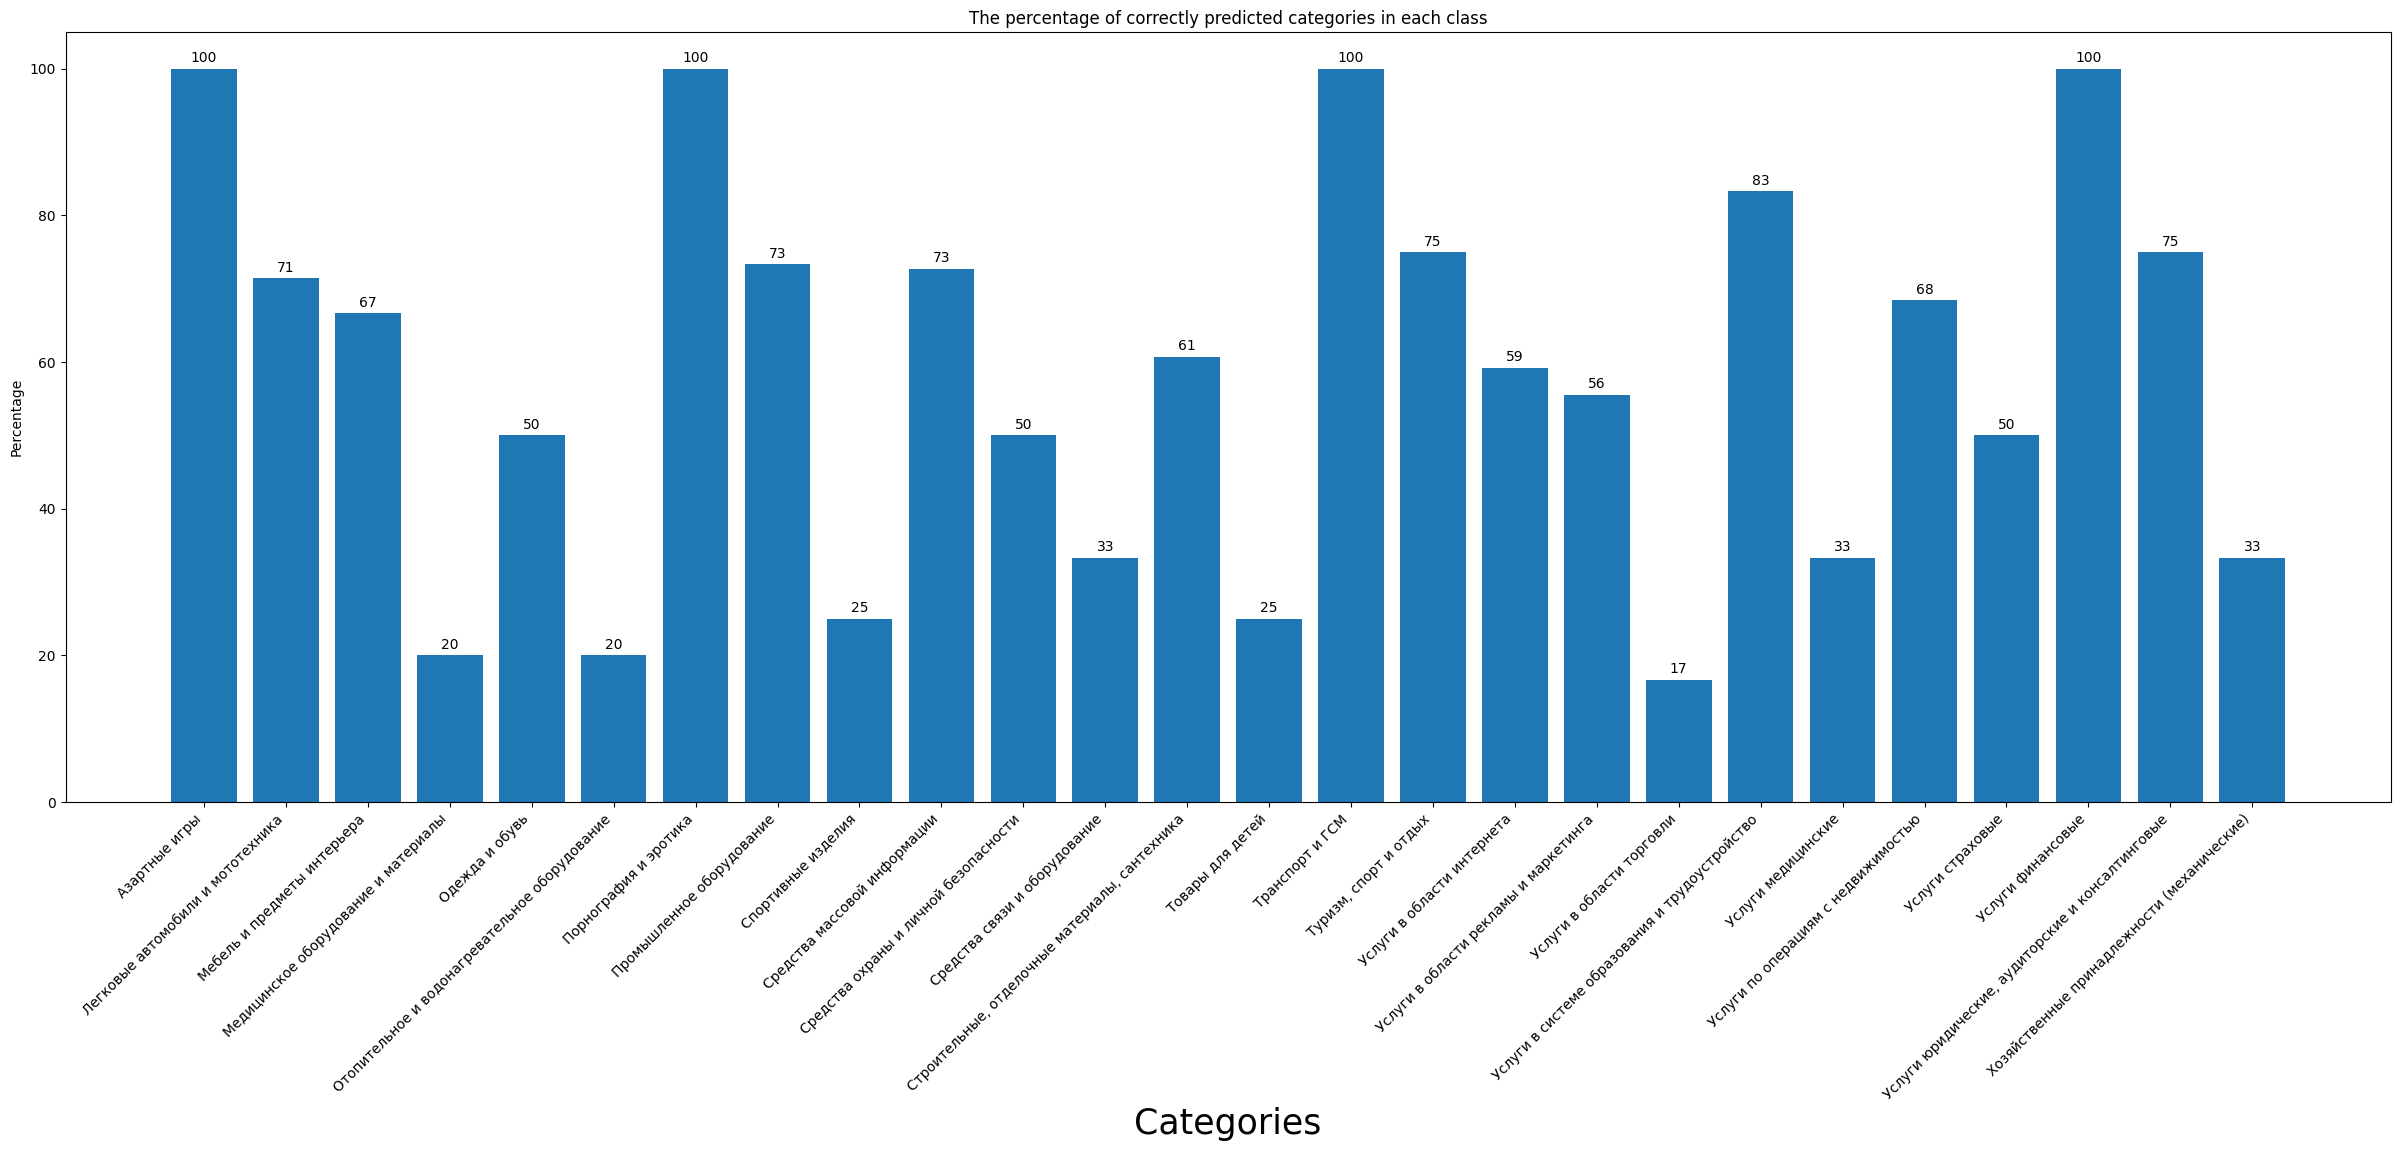

In [ ]:
filtered = {k: v for k, v in category_rate_pred.items() if v != 0}
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(filtered.keys(), filtered.values())

for i, (key, value) in enumerate(filtered.items()):
    ax.text(i, value + 0.5, str(round(value)), ha='center', va='bottom')

ax.set_title("The percentage of correctly predicted categories in each class")
ax.set_xlabel("Categories")
ax.set_ylabel("Percentage")
ax.xaxis.label.set_size(25)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.savefig("category_rate_pred.png")
plt.plot()

 Второе предположение об ошибках в предсказаниях - есть очень похожие между собой категории. Посмотрим на них.

In [ ]:
df_test[df_test['category'] == "Автосервисы"][['category', 'pred']]

,category,pred
1061,Автосервисы,Транспорт и ГСМ
0,Автосервисы,Услуги в области интернета
2093,Автосервисы,Транспорт и ГСМ
1764,Автосервисы,Одежда и обувь
2700,Автосервисы,Транспорт и ГСМ


категории Автосервисы и Транспорт действительно между собой могут быть похожи. Они связаны как логически, так и общим набором слов,  которые могут встретиться в текстах обеих категорий.

In [ ]:
df_test[df_test['category'] == "Бытовая техника"][['input', 'category', 'pred']]

,input,category,pred
1399,Главная — «Смарт Стоун»,Бытовая техника,Услуги в системе образования и трудоустройство
637,Бытовая техника. Все что нужно знать домохозяи...,Бытовая техника,Промышленное оборудование
1586,POWERMAN - Источники бесперебойного питания (...,Бытовая техника,"Туризм, спорт и отдых"


Ещ один пример перекликающихся категорий: Бытовая техника и Промышленное оборудование. Наверняка в текстах часто можно встретить такие слова как: "машина", "запчасть", "установка". Однако, модельне назвала соседнюю категорию в подавляющем большинстве. Так что в данном случае это скорее совпадение, чем правило.

### Сравнение с BERT

In [ ]:
from datasets import Dataset

In [ ]:
from evaluate import load
import numpy as np

def compute_metrics(eval_pred):
    metric_acc = load("accuracy")
    metric_precision = load("precision")
    metric_recall = load("recall")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    if labels.ndim == 2:  # one-hot case
        labels = np.argmax(labels, axis=1)

    results = {}
    results.update(metric_acc.compute(predictions=predictions, references=labels))
    results.update(metric_precision.compute(
        predictions=predictions, references=labels, average="macro"
    ))
    results.update(metric_recall.compute(
        predictions=predictions, references=labels, average="macro"
    ))
    return results

In [ ]:
def preprocess(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
tokenized_train = Dataset.from_pandas(df_train[['tokens', 'category_encoded']].rename(columns={'tokens':'text', 'category_encoded':'labels'})).map(preprocess)
tokenized_test = Dataset.from_pandas(df_val[['tokens', 'category_encoded']].rename(columns={'tokens':'text', 'category_encoded':'labels'})).map(preprocess)

Map:   0%|          | 0/2376 [00:00<?, ? examples/s]

Map:   0%|          | 0/297 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(categories))
args = TrainingArguments("output", num_train_epochs=3, report_to="none")
trainer = Trainer(model, args, train_dataset=tokenized_train, eval_dataset=tokenized_test, compute_metrics=compute_metrics)
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.107700


TrainOutput(global_step=891, training_loss=0.09026675111918336, metrics={'train_runtime': 229.8965, 'train_samples_per_second': 31.005, 'train_steps_per_second': 3.876, 'total_flos': 469150162956288.0, 'train_loss': 0.09026675111918336, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.06667758524417877, 'eval_accuracy': 0.2978117996959389, 'eval_precision': 0.14468329683699074, 'eval_recall': 0.24026432813392323, 'eval_runtime': 4.0345, 'eval_samples_per_second': 73.614, 'eval_steps_per_second': 9.419, 'epoch': 3.0}


|           | bert-base-uncased | count_vectorizer (Tanh) |
|-----------|-------------------|-------------------------|
| Precision | 0.144             | 0.53                    |
| Recall    | 0.24              | 0.55                    |